In this tutorial, we are first going to generate data that are linearly separable, then we will perform a logistic regression on them.

# Generating Data


In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

Let's see how it looks.

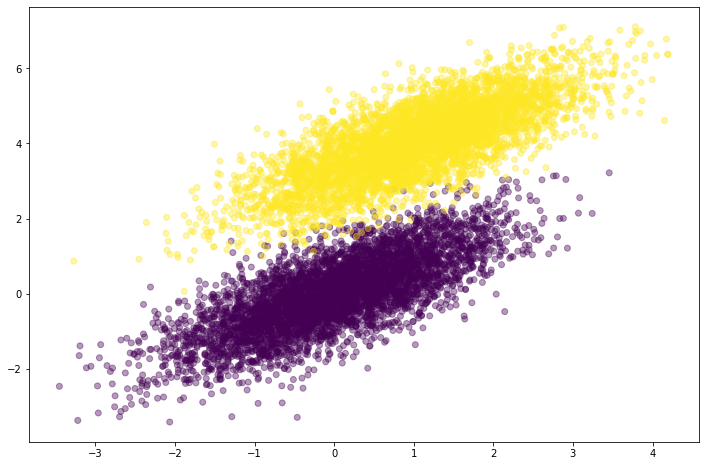

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)

# Picking a Link Function
Generalized linear models usually tranform a linear model of the predictors by using a [link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function). In logistic regression, the link function is the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). We can implement this really easily.

In [28]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

# Maximizing the Likelihood

In logistic regression, we want to model a logistic like model from a binary classification problem as seen in lectures:
$$P_{\rm model}(l({\bf x})=1) = \frac 1{1+\exp(-{\bf \theta} \cdot {\bf x})}~~~ \text{&}~~~ P_{\rm model}(l({\bf x})=0) = \frac {\exp(-{\bf \theta} \cdot {\bf x})}{1+\exp(-{\bf \theta} \cdot {\bf x})}$$

We now want to use cross entropy as loss function : 
$${\rm Loss} = - \sum_{\rm dataset} \sum_{l=0,1} P_{\rm true}(x=l) \log(P_{\rm model}(x=l)) $$
where $y$ is the target class, $x_{i}$ represents an individual data point, and $\theta$ is the weights vector.
***Exercise*** Show that the cross entropy can be written :
$${\rm Loss} =  \sum_{\rm dataset} - y_i {\bf \theta} \cdot {\bf x}_i  + \log{(1+\exp({\bf \theta} \cdot {\bf x}_i ))} $$


In [29]:
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = 0
    for i in range(np.size(target)):
        ll += -np.dot(target[i],weights,feat ures[i]) + np.log(1+np.exp(np.dot(weights,features[i])))
    return ll

## Calculating the Gradient

Now we need an equation for the gradient of the log-likelihood. By taking the derivative of the equation above and reformulating in matrix form, the gradient becomes: 

***Exercise*** Compute the gradient of the loss function and show that it can be written in the following way :
$$\begin{equation}
\bigtriangledown {\rm Loss } = -X^{T}(Y - Predictions)
\end{equation}$$


# Building the Logistic Regression Function

Finally, I'm ready to build the model function. I'll add in the option to calculate the model with an intercept, since it's a good option to have.

In [33]:
def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with log likelihood gradient
        #output_error_signal = #write what you want
        
        gradient = -np.dot(np.transpose(features),target-predictions)
        weights += -np.dot(gradient,learning_rate)

        # Print log-likelihood every so often
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))
        
    return weights

Time to do the regression.

In [37]:
intercept = np.ones((simulated_separableish_features.shape[0], 1))
data_with_intercept = np.hstack((intercept, simulated_separableish_features))
weights = logistic_regression(data_with_intercept, simulated_labels,
                     num_steps = 50000, learning_rate = 5e-5, add_intercept=False)

[7639.02895095 7022.57684745 5137.74476741]
[796958.82271042 781886.21253103 735800.97892554]
[796958.82271042 781886.21253103 735800.97892554]
[796958.82271042 781886.21253103 735800.97892554]
[796958.82271042 781886.21253103 735800.97892554]


In [38]:
print(weights)

[ 0.          3.01452204 12.23156876]


***Exercise *** As usual in python someone has already done a way better job than us, look at the doc on how to do a logistic regression using some python library, and compare the weights from that function and your weights

In [39]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1e5,multi_class='multinomial',penalty='l2', solver='sag', tol=0.1)
clf.fit(data_with_intercept, simulated_labels)
print(clf.coef_)

[[0.         0.37463909 1.52011621]]


# What's the Accuracy?
To get the accuracy, I just need to use the final weights to get the logits for the dataset (`final_scores`). Then I can use `sigmoid` to get the final predictions and round them to the nearest integer (0 or 1) to get the predicted class.

In [40]:
def line(x,a,b,c):
    return -x*b/c-a/c
def myline(x):
    return line(x,weights[0],weights[1],weights[2])

final_scores = np.dot(data_with_intercept, weights)
preds = np.round(sigmoid(final_scores))

print('Accuracy: {0}'.format((preds == simulated_labels).sum().astype(float) / len(preds)))


Accuracy: 1.0


Nearly perfect (which makes sense given the data). We should only have made mistakes right in the middle between the clusters. Let's make sure that's what happened. In the following plot, blue points are correct predictions, and red points are incorrect

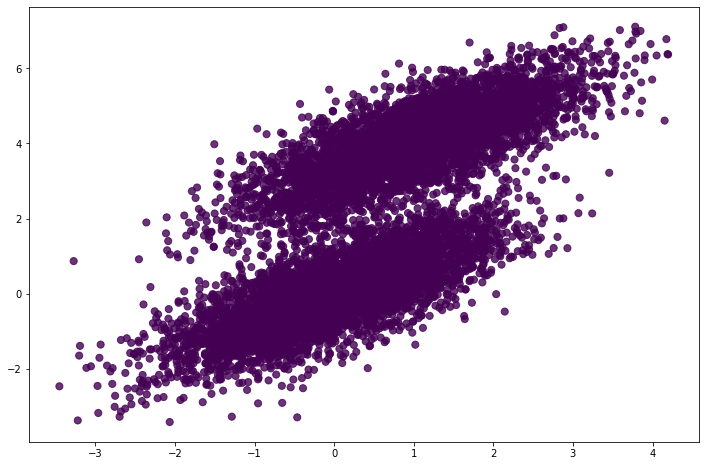

In [41]:
plt.figure(figsize = (12, 8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = preds == simulated_labels - 1, alpha = .8, s = 50)

# Bonus
Separate the dataset into a training and test set and plot the evolution of the value of the loss over the number of iterations. You can also do the same exercise when adding a regularisation term (L1 or L2) and see what happens